In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml.classification import LogisticRegression

In [0]:
df = spark.sql("select * from default.reviews_train")
df.show(5)

+--------+-------+--------+-----------+--------------+----------+---------------+--------------------+--------------------+--------------+-----+
|reviewID|overall|verified| reviewTime|    reviewerID|      asin|   reviewerName|          reviewText|             summary|unixReviewTime|label|
+--------+-------+--------+-----------+--------------+----------+---------------+--------------------+--------------------+--------------+-----+
|       1|    5.0|    true|10 17, 2015|A1HP7NVNPFMA4N|0700026657|    Ambrosia075|This game is a bi...|but when you do i...|    1445040000|    0|
|       2|    5.0|   false|03 30, 2005|A1REUF3A1YCPHM|0001713353|    TW Ervin II|The King, the Mic...|A story children ...|    1112140800|    0|
|       3|    5.0|    true| 11 5, 2015| A8LUWTIPU9CZB|0560467893|   Linda Fahner|Great product, lo...|          Five Stars|    1446681600|    0|
|       4|    5.0|    true|06 20, 2016| AVP0HXC9FG790|0001713353|Amazon Customer|  The kids loved it!|          Five Stars|    146

In [0]:
df = df.dropDuplicates(['reviewerID','asin'])
# Calculate the sum of missing values for each column in the DataFrame
missing_values = df.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
# Show the sum of missing values for each column
missing_values.show()

+--------+-------+--------+----------+----------+----+------------+----------+-------+--------------+-----+
|reviewID|overall|verified|reviewTime|reviewerID|asin|reviewerName|reviewText|summary|unixReviewTime|label|
+--------+-------+--------+----------+----------+----+------------+----------+-------+--------------+-----+
|       0|      0|       0|         0|         0|   0|         217|         0|    351|             0|    0|
+--------+-------+--------+----------+----------+----+------------+----------+-------+--------------+-----+



In [0]:
# Data Cleaning
df = df.withColumn("reviewTime", to_date(from_unixtime(df.unixReviewTime))).drop("unixReviewTime")
df = df.withColumn("verified", df.verified.cast("int"))

In [0]:
# Feature Engineering 
df = df.withColumn("len", f.length("reviewText"))
df = df.withColumn('days', datediff(current_date(),col("reviewTime"))) #inspired from ChatGPT
df = df.withColumn("reviewText", concat(col("reviewText"), col("summary")))
df = df.drop("summary","reviewerName")
df.head(2)

[Row(reviewID=3131321, overall=1.0, verified=1, reviewTime=datetime.date(2014, 2, 7), reviewerID='A0380485C177Q6QQNJIX', asin='B003N5ZYOG', reviewText='bad very bad the conect drums is brokenbad very bad the conect drums is broken', label=0, len=39, days=3532),
 Row(reviewID=2541277, overall=2.0, verified=1, reviewTime=datetime.date(2017, 2, 18), reviewerID='A0457350OAOAFTV3LPDA', asin='B001PKU1YO', reviewText="This dresser has been a disaster almost since we put it together. Due to our college-kid budget, we purchased this product hoping for the best (our old dresser had seen its last days). The customer service has helped manage the poor quality of the drawers, but each time they send (free of charge, and from wonderful representatives) new drawer bottoms, they're the wrong way thickness and don't fit. If you purchase this, know you'll have a lot of extra work down the road. There's a lot of rigging you'll have to do yourself. The exterior is very nice. The only reason this isn't a 1

In [0]:
# set seed for reproducibility
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed = 47)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count())) 

Training Dataset Count: 2323290
Test Dataset Count: 580871


In [0]:
# Indexing ASIN and Overall Columns
asin_overall_indexer = StringIndexer(
    inputCols=["asin", "overall"],
    outputCols=["asinIndex", "overallIndex"],
    handleInvalid='keep'
)

# Encoding Feature Columns
feature_encoder = OneHotEncoder(
    inputCols=["asinIndex", "overallIndex", "days", "len", "verified"],
    outputCols=["asinVec", "overallVec", "daysVec", "lenVec", "verifiedVec"],
    handleInvalid='keep',
    dropLast=True
)

# Assembling Documents
review_assembler = DocumentAssembler().setInputCol("reviewText").setOutputCol("reviewDocument")

# Detectiong Sentence
review_sentence_detector = SentenceDetector().setInputCols(["reviewDocument"]).setOutputCol("reviewSentence")

# Tokenizing Sentences
review_tokenizer = RegexTokenizer().setInputCols(["reviewSentence"]).setOutputCol("reviewToken").setToLowercase(True).setPattern("\\s+")

# Normalizing Tokens
review_normalizer = Normalizer().setInputCols(["reviewToken"]).setOutputCol("reviewNormalized")

# Lemmatizing Tokens
review_lemmatizer = LemmatizerModel.pretrained().setInputCols(["reviewNormalized"]).setOutputCol("reviewLemma")

# Cleaning StopWords
review_stopwords_cleaner = StopWordsCleaner().setInputCols("reviewLemma").setOutputCol("reviewCleanTokens").setCaseSensitive(False)

# Finishing Transformation
review_finisher = Finisher().setInputCols(["reviewCleanTokens"]).setOutputCols(["reviewTokenFeatures"]).setOutputAsArray(True).setCleanAnnotations(False)

# Calculating TF-IDF
review_tf = CountVectorizer(inputCol="reviewTokenFeatures", outputCol="reviewRawFeatures", vocabSize=10000, minTF=1, minDF=50, maxDF=0.40)
review_idf = IDF(inputCol="reviewRawFeatures", outputCol="reviewIDF")

# Assembling Final Features
final_feature_assembler = VectorAssembler(
    inputCols=['overallVec', 'verifiedVec', 'asinVec', 'daysVec', 'lenVec', "reviewIDF"],
    outputCol="features",
    handleInvalid='keep'
)

logistic_regression_model = LogisticRegression(maxIter=500, regParam = 0.01, elasticNetParam=0)

# Creating the Pipeline
nlp_pipeline = Pipeline(stages=[
    asin_overall_indexer,
    feature_encoder,
    review_assembler, review_sentence_detector, review_tokenizer, review_normalizer, review_lemmatizer, review_stopwords_cleaner, review_finisher, review_tf, review_idf,
    final_feature_assembler,
    logistic_regression_model,
])


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [0]:
pipelineFit = nlp_pipeline.fit(df)

In [0]:
# Extracting the regression coefficients and feature names
lr_model = pipelineFit.stages[-1]
coefficients = lr_model.coefficients
feature_names = pipelineFit.stages[-2].getInputCols()

# Pairing feature names with coefficients and sorting in descending order
coefficients_with_names = list(zip(feature_names, coefficients))
sorted_coefficients_with_names = sorted(coefficients_with_names, key=lambda x: x[1], reverse=True)

# Displaying the sorted coefficients with feature names
for feature, coeff in sorted_coefficients_with_names:
    print(feature, ":", coeff)

daysVec : 1.4664576708874841
lenVec : 0.5915948972564071
asinVec : 0.10259340323579429
reviewIDF : 0.0
overallVec : -0.24089398704471185
verifiedVec : -0.33395427680437234


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

predictions = pipelineFit.transform(testData)
predictions.columns

from pyspark.sql.functions import col

# Get the 'label' and 'prediction' columns and compute the crosstab
confusion_matrix = predictions.select("label", "prediction").groupBy("label").pivot("prediction").count().na.fill(0)
confusion_matrix.show()

# evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
# print('Test Area Under ROC', evaluator.evaluate(predictions)) 


+-----+------+-----+
|label|   0.0|  1.0|
+-----+------+-----+
|    1| 46722|58954|
|    0|459602|16977|
+-----+------+-----+



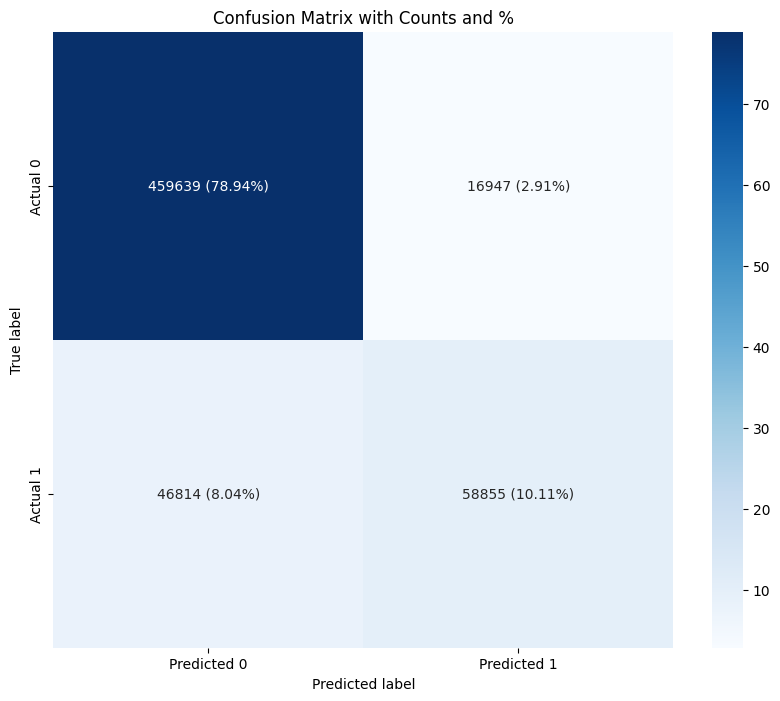

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix values
confusion = np.array([[459639, 16947],
                     [46814, 58855]])

# Normalize the confusion matrix
total = np.sum(confusion)
percentage_matrix = (confusion / total) * 100

# Create annotations: combine raw counts (TN, FP, FN, TP) with their respective percentages
annot = np.array([["{} ({:.2f}%)".format(val, percentage_matrix[i, j]) 
                  for j, val in enumerate(row)] for i, row in enumerate(confusion)])

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(percentage_matrix, annot=annot, fmt='', cmap="Blues", 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Counts and %')
plt.show()


In [0]:
test_df = spark.sql("select * from default.reviews_test")
test_df.show(5)

+--------+-------+--------+-----------+--------------+----------+------------+--------------------+--------------------+--------------+
|reviewID|overall|verified| reviewTime|    reviewerID|      asin|reviewerName|          reviewText|             summary|unixReviewTime|
+--------+-------+--------+-----------+--------------+----------+------------+--------------------+--------------------+--------------+
|80000001|    4.0|   false|07 27, 2015|A1JGAP0185YJI6|0700026657|      travis|I played it a whi...|But in spite of t...|    1437955200|
|80000002|    5.0|    true| 03 3, 2014|A1WK5I4874S3O2|0700026657|  WhiteSkull|I bought this gam...|A very good game ...|    1393804800|
|80000003|    5.0|    true|01 12, 2013|A1YDQQJDRHM0FJ|0001713353|       Leila|I am very happy w...|One of our famili...|    1357948800|
|80000004|    5.0|    true|11 20, 2011|A2E6AHFDJ3JBAZ|0681795107|    robosolo|I purchased two o...|Insulated stainle...|    1321747200|
|80000005|    5.0|   false|06 28, 2011|A38NXTZUF

In [0]:
# Data Cleaning
test_df = test_df.withColumn("reviewTime", to_date(from_unixtime(test_df.unixReviewTime))).drop("unixReviewTime")
test_df = test_df.withColumn("verified", test_df.verified.cast("int"))
# Feature Engineering 
test_df = test_df.withColumn("len", f.length("reviewText"))
test_df = test_df.withColumn('days', datediff(current_date(),col("reviewTime")))
test_df = test_df.withColumn("reviewText", concat(col("reviewText"), col("summary")))
test_df = test_df.drop("summary")

In [0]:
predictions = pipelineFit.transform(test_df)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

probelement=udf(lambda v:float(v[1]),FloatType())
submission_data = predictions.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
display(submission_data.select('reviewID', 'label'))

reviewID,label
80000001,0.012054286
80000002,0.056594033
80000003,0.01755382
80000004,0.20892479
80000005,0.7579243
80000006,0.4001667
80000007,0.11984319
80000008,0.29446298
80000009,0.09817424
80000010,0.76023495
